In [3]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import Normalizer

In [4]:
# Print dataset file structure
def print_dir_structure(root_dir, indent=""):
    for item in os.listdir(root_dir):
        path = os.path.join(root_dir, item)
        if os.path.isdir(path):
            print(f"{indent} {item}")
            print_dir_structure(path, indent + "\t")
        else:
            print(f"{indent} {item}")

root_dir = "../Dataset"
print(root_dir)
print_dir_structure(root_dir)

../Dataset
 Benign&Bruteforce
	 benign
		 BenignTraffic.pcap_Flow.csv
		 BenignTraffic1.pcap_Flow.csv
		 BenignTraffic2.pcap_Flow.csv
		 BenignTraffic3.pcap_Flow.csv
	 BruteForce
		 DictionaryBruteForce.pcap_Flow.csv
 DDoS
	 DDoS ACK Fragmentation
		 DDoS-ACK_Fragmentation.pcap_Flow.csv
		 DDoS-ACK_Fragmentation1.pcap_Flow.csv
		 DDoS-ACK_Fragmentation10.pcap_Flow.csv
		 DDoS-ACK_Fragmentation11.pcap_Flow.csv
		 DDoS-ACK_Fragmentation12.pcap_Flow.csv
		 DDoS-ACK_Fragmentation2.pcap_Flow.csv
		 DDoS-ACK_Fragmentation3.pcap_Flow.csv
		 DDoS-ACK_Fragmentation4.pcap_Flow.csv
		 DDoS-ACK_Fragmentation5.pcap_Flow.csv
		 DDoS-ACK_Fragmentation6.pcap_Flow.csv
		 DDoS-ACK_Fragmentation7.pcap_Flow.csv
		 DDoS-ACK_Fragmentation8.pcap_Flow.csv
		 DDoS-ACK_Fragmentation9.pcap_Flow.csv
	 DDoS ICMP Flood
		 DDoS-ICMP_Flood.pcap_Flow.csv
		 DDoS-ICMP_Flood1.pcap_Flow.csv
		 DDoS-ICMP_Flood10.pcap_Flow.csv
		 DDoS-ICMP_Flood11.pcap_Flow.csv
		 DDoS-ICMP_Flood12.pcap_Flow.csv
		 DDoS-ICMP_Flood13.pcap_F

In [5]:
# Define categories
categories = {
    "Benign": ["Benign&Bruteforce/benign"],
    "BruteForce": ["Benign&Bruteforce/BruteForce"],
    "DDoS": ["DDoS"],
    "DoS": ["DoS"],
    "Mirai": ["Mirai"],
    "Spoofing": ["spoofing"],
    "SQLInjection": ["sqlinjection"],
    "VulnerabilityScan": ["VulnerabilityScan"],
    "XSS": ["XSS"],
    "UploadingAttack": ["Uploading_Attack"]
}

# Scan csv files in each category
category_files = {}
for category, paths in categories.items():
    file_list = []
    for category_path in paths:
        full_path = os.path.join(root_dir, category_path)
        for root, _, files in os.walk(full_path):
            for f in files:
                if f.endswith(".csv"):
                    file_list.append(os.path.join(root, f))
    category_files[category] = file_list
print(category_files["Benign"])

['../Dataset\\Benign&Bruteforce/benign\\BenignTraffic.pcap_Flow.csv', '../Dataset\\Benign&Bruteforce/benign\\BenignTraffic1.pcap_Flow.csv', '../Dataset\\Benign&Bruteforce/benign\\BenignTraffic2.pcap_Flow.csv', '../Dataset\\Benign&Bruteforce/benign\\BenignTraffic3.pcap_Flow.csv']


In [6]:
# Define features
get_columns = pd.read_csv(category_files["Benign"][0])
columns = get_columns.columns.tolist()

# Extract data from each category
all_samples = []

for category, files in category_files.items():
    num_files = len(files)

    # Skip empty categories
    if num_files == 0:
        continue

    # Set sampling size based on category
    NUM_SAMPLES = 50000 if category == "Benign" else 5555

    # Read all CSV files
    dataframes = []
    for f in files:
        df = pd.read_csv(f)
        df.columns = columns
        dataframes.append(df)

    # Compute the total number of samples available
    total_available = sum(len(df) for df in dataframes)

    # If the number of samples in the class is not enough, extract all available samples
    if total_available <= NUM_SAMPLES:
        category_df = pd.concat(dataframes, ignore_index=True)
    else:
        category_samples = []
        remaining_samples = NUM_SAMPLES

        # First, take the minimum possible from each file
        for df in dataframes:
            extract = min(len(df), remaining_samples // len(files))
            category_samples.append(df.sample(n=extract, random_state=42))
            remaining_samples -= extract

        # If still need more, distribute the remainder randomly
        if remaining_samples > 0:
            available_files = [df for df in dataframes if len(df) > NUM_SAMPLES // len(files)]
            for df in available_files:
                if remaining_samples <= 0:
                    break
                extra = min(len(df), remaining_samples)
                category_samples.append(df.sample(n=extra, random_state=42))
                remaining_samples -= extra

        # Merge all sampled data
        category_df = pd.concat(category_samples, ignore_index=True)

    category_df["Label"] = category  # Add label column
    all_samples.append(category_df)

# Merge all categories into a single dataset
extracted_dataset = pd.concat(all_samples, ignore_index=True)
extracted_dataset.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.137.133-192.168.137.1-53083-53-17,192.168.137.133,53083,192.168.137.1,53,17,07/10/2022 07:17:29 PM,40091,1,1,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,192.168.137.133-192.168.137.1-34173-53-17,192.168.137.133,34173,192.168.137.1,53,17,07/10/2022 07:45:10 PM,114039,1,1,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
2,192.168.137.227-8.8.8.8-50664-53-17,192.168.137.227,50664,8.8.8.8,53,17,07/10/2022 04:17:53 PM,131314,1,1,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
3,192.168.137.41-192.168.137.1-60462-53-17,192.168.137.41,60462,192.168.137.1,53,17,07/10/2022 06:28:11 PM,16452,1,1,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,192.168.137.245-47.254.89.110-19274-32100-17,192.168.137.245,19274,47.254.89.110,32100,17,07/10/2022 09:12:16 PM,100400129,5,5,...,8,128562.0,4110.726213,133735.0,124588.0,24937178.0,12621.024443,24951903.0,24921500.0,Benign


In [7]:
extracted_dataset['Label'].value_counts()

Label
Benign               50000
DDoS                  5555
SQLInjection          5555
DoS                   5555
Mirai                 5555
Spoofing              5555
VulnerabilityScan     5555
BruteForce            3619
XSS                   3377
UploadingAttack       1348
Name: count, dtype: int64

In [8]:
# Drop unnecessary columns, such as ID, IP, Port, Protocol and TimeStamp
balanced_dataset = extracted_dataset.drop(['Flow ID','Src IP','Src Port','Dst IP','Dst Port','Protocol','Timestamp', 'Flow Bytes/s', 'Flow Packets/s'], axis=1)
balanced_dataset.head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,40091,1,1,35.0,51.0,35.0,35.0,35.0,0.0,51.0,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,114039,1,1,36.0,52.0,36.0,36.0,36.0,0.0,52.0,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
2,131314,1,1,54.0,70.0,54.0,54.0,54.0,0.0,70.0,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
3,16452,1,1,28.0,44.0,28.0,28.0,28.0,0.0,44.0,...,8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,100400129,5,5,540.0,40.0,108.0,108.0,108.0,0.0,8.0,...,8,128562.0,4110.726213,133735.0,124588.0,24937178.0,12621.024443,24951903.0,24921500.0,Benign


In [9]:
# Drop missing values
balanced_dataset = balanced_dataset.dropna()

# Random over sampling
ros = RandomOverSampler(sampling_strategy={'BruteForce': 5555, 'XSS': 5555, 'UploadingAttack': 5555}, random_state=0)
X, y = ros.fit_resample(balanced_dataset.iloc[:, :-1], balanced_dataset.iloc[:, -1])
processed_data = pd.DataFrame(X)
processed_data['Label'] = y
processed_data['Label'].value_counts()

Label
Benign               50000
BruteForce            5555
DDoS                  5555
DoS                   5555
Mirai                 5555
Spoofing              5555
SQLInjection          5555
VulnerabilityScan     5555
XSS                   5555
UploadingAttack       5555
Name: count, dtype: int64

In [10]:
processed_data['Label'] = processed_data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)
processed_data['Label'].value_counts()

Label
0    50000
1    49995
Name: count, dtype: int64

<Axes: title={'center': 'Label Distribution'}>

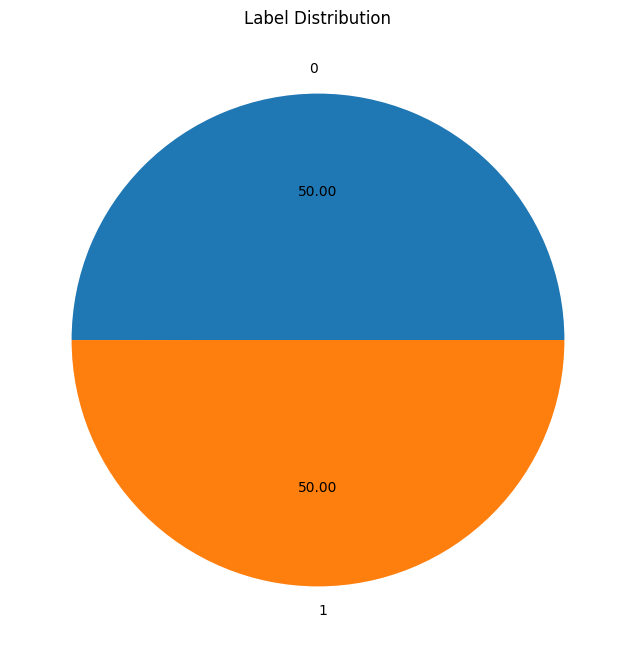

In [11]:
plt.title("Label Distribution")
processed_data.groupby('Label').size().plot(kind='pie', autopct='%.2f', figsize=(8,8))

In [12]:
# Assign clients ID
processed_data["Client_ID"] = np.random.randint(1, 6, size=len(processed_data))
processed_data["Client_ID"].value_counts()

Client_ID
1    20137
4    20057
2    20031
5    19952
3    19818
Name: count, dtype: int64

<Axes: title={'center': 'Clients Distribution'}>

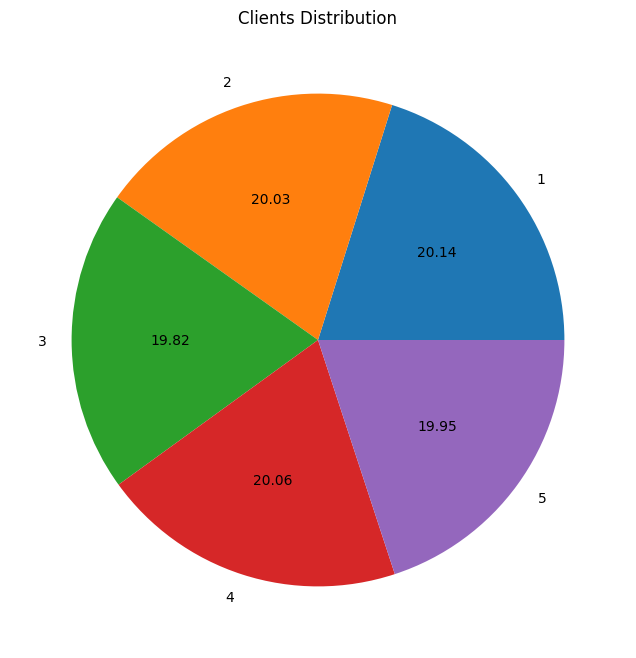

In [13]:
plt.title("Clients Distribution")
processed_data.groupby('Client_ID').size().plot(kind='pie', autopct='%.2f', figsize=(8,8))

In [14]:
# Normalize the data
scaler = Normalizer(norm='l2')
normalize_data = processed_data.columns[:-2]
processed_data[normalize_data] = scaler.fit_transform(processed_data[normalize_data])
processed_data.head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Client_ID
0,0.499999,1.247159e-05,1.247159e-05,0.000437,6.360511e-04,4.365057e-04,4.365057e-04,4.365057e-04,0.0,6.360511e-04,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,1
1,0.500000,4.384463e-06,4.384463e-06,0.000158,2.279921e-04,1.578407e-04,1.578407e-04,1.578407e-04,0.0,2.279921e-04,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,5
2,0.500000,3.807665e-06,3.807665e-06,0.000206,2.665366e-04,2.056139e-04,2.056139e-04,2.056139e-04,0.0,2.665366e-04,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,2
3,0.499992,3.039095e-05,3.039095e-05,0.000851,1.337202e-03,8.509467e-04,8.509467e-04,8.509467e-04,0.0,1.337202e-03,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0,5
4,0.523786,2.608494e-08,2.608494e-08,0.000003,2.086795e-07,5.634346e-07,5.634346e-07,5.634346e-07,0.0,4.173590e-08,...,0.000671,0.000021,0.000698,0.00065,0.130097,0.000066,0.130174,0.130015,0,1


In [15]:
# Shuffle the dataset
processed_data = processed_data.sample(frac=1).reset_index(drop=True)
processed_data.head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Client_ID
0,0.499999,8.441798e-06,8.441798e-06,0.000338,0.000473,0.000338,0.000338,0.000338,0.000000,0.000473,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1,4
1,0.599448,6.794593e-06,9.059457e-06,0.000568,0.000016,0.000568,0.000000,0.000189,0.000328,0.000016,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1,5
2,0.386390,1.463462e-06,7.317308e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1,4
3,0.452218,8.918566e-06,0.000000e+00,0.003104,0.000000,0.000776,0.000776,0.000776,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0,5
4,0.633880,1.235488e-07,2.059147e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002471,0.0,0.002471,0.002471,0.15471,0.031547,0.197856,0.124066,1,2


In [16]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99995 entries, 0 to 99994
Data columns (total 76 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Flow Duration               99995 non-null  float64
 1   Total Fwd Packet            99995 non-null  float64
 2   Total Bwd packets           99995 non-null  float64
 3   Total Length of Fwd Packet  99995 non-null  float64
 4   Total Length of Bwd Packet  99995 non-null  float64
 5   Fwd Packet Length Max       99995 non-null  float64
 6   Fwd Packet Length Min       99995 non-null  float64
 7   Fwd Packet Length Mean      99995 non-null  float64
 8   Fwd Packet Length Std       99995 non-null  float64
 9   Bwd Packet Length Max       99995 non-null  float64
 10  Bwd Packet Length Min       99995 non-null  float64
 11  Bwd Packet Length Mean      99995 non-null  float64
 12  Bwd Packet Length Std       99995 non-null  float64
 13  Flow IAT Mean               999

In [17]:
processed_data.describe()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Client_ID
count,99995.000000,9.999500e+04,9.999500e+04,99995.000000,99995.000000,9.999500e+04,99995.000000,9.999500e+04,9.999500e+04,99995.000000,...,99995.000000,99995.000000,99995.000000,99995.000000,99995.000000,99995.000000,99995.000000,99995.000000,99995.000000,99995.000000
mean,0.494183,5.280921e-05,1.169272e-05,0.001043,0.000847,6.013639e-04,0.000495,5.259236e-04,5.196881e-05,0.000670,...,0.004613,0.001285,0.006262,0.003645,0.052099,0.003642,0.056059,0.048967,0.499975,2.996560
std,0.130915,1.017843e-03,3.705386e-05,0.005368,0.004567,2.314264e-03,0.002210,2.241942e-03,3.613006e-04,0.001942,...,0.022486,0.008665,0.028175,0.020249,0.102039,0.018690,0.106760,0.100285,0.500002,1.415821
min,0.000000,3.167073e-09,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.472610,1.439902e-07,1.198384e-08,0.000001,0.000000,3.338993e-07,0.000000,1.845027e-07,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.500000,3.138820e-06,2.162742e-06,0.000041,0.000021,2.495640e-05,0.000001,1.695847e-05,0.000000e+00,0.000014,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.563790,9.979918e-06,8.037613e-06,0.000461,0.000636,3.900345e-04,0.000179,2.178393e-04,1.144242e-07,0.000594,...,0.000000,0.000000,0.000000,0.000000,0.036986,0.000000,0.048757,0.030520,1.000000,4.000000
max,0.826754,1.111111e-01,2.589927e-03,0.489795,0.523862,2.255012e-01,0.225501,2.255012e-01,4.726819e-02,0.044167,...,0.421344,0.260438,0.421344,0.421344,0.435401,0.301027,0.464178,0.435401,1.000000,5.000000


In [18]:
# Export the processed dataset
processed_data.to_csv("dataset_binary.csv", index=False, header=True)